# Ions

In `braincell`, ions are divided into the following three base classes:

* `Calcium`: calcium ions
* `Potassium`: potassium ions
* `Sodium`: sodium ions

## Using Existing Ions

First, let's explain how to use the existing ions.

In practice, calling models related to these ions is very straightforward.

### Ion Usage

Similarly, let's look at an example of modeling an HH neuron:

In [12]:
import braincell

class HH(braincell.SingleCompartment):
    def __init__(self, in_size):
        super().__init__(in_size, C=Cm, solver='ind_exp_euler')
        self.na = braincell.ion.SodiumFixed(in_size, E=50. * u.mV)
        self.na.add_elem(
            INa=braincell.channel.INa_TM1991(in_size, g_max=(100. * u.mS * u.cm ** -2) * area, V_sh=-63. * u.mV)
        )

        self.k = braincell.ion.PotassiumFixed(in_size, E=-90 * u.mV)
        self.k.add_elem(
            IK=braincell.channel.IK_TM1991(in_size, g_max=(30. * u.mS * u.cm ** -2) * area, V_sh=-63. * u.mV)
        )

        self.IL = braincell.channel.IL(in_size, E=-60. * u.mV, g_max=(5. * u.nS * u.cm ** -2) * area)

First, after importing the relevant modules, we need to create specific model objects in the `__init__` method.

Here, using sodium ion `na` as an example, we use `SodiumDetailed` to create a calcium ion model.
We only need to set the parameters of `SodiumDetailed` according to definitions in the literature or the actual scenario.

As you can see, using pre-modeled ion models is very simple—just a straightforward call is enough.

Similarly, we can perform simple simulations by calling a specific `Ion` type.
For example, we can use `CalciumDetailed` to simulate the dynamic changes of intracellular calcium reversal potential over time.


In [13]:
import matplotlib.pyplot as plt
import brainstate
import braintools
import braincell
import brainunit as u

In [14]:
ca = braincell.ion.CalciumDetailed(size=1)
V = -65 * u.mV
ca.init_state(V)

dt = 0.1 * u.ms
steps = 1000

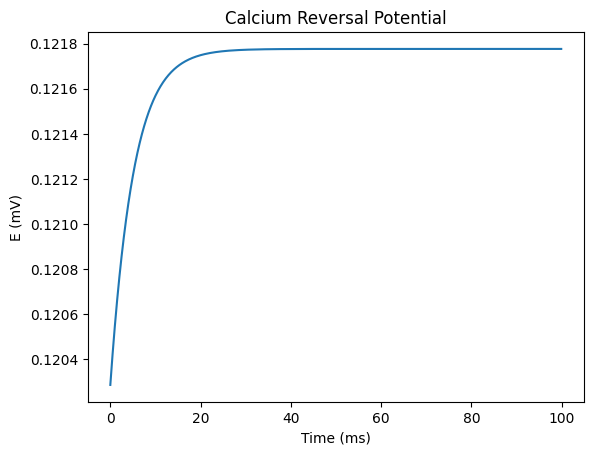

In [15]:
def run_calcium(i):
    t = i * dt
    with brainstate.environ.context(i=i, t=t, dt=dt):
        # Inward Currents
        input_current = -0.1 * u.uA / u.cm**2
        ca.C.derivative = input_current / (2 * u.faraday_constant * ca.d) + (ca.C_rest - ca.C.value) / ca.tau
        ca.C.value = ca.C.value + ca.C.derivative * dt
    return ca.E

indices = u.math.arange(steps)
E = brainstate.transform.for_loop(run_calcium, indices)

plt.plot(indices * dt, E)
plt.xlabel('Time (ms)')
plt.ylabel('E (mV)')
plt.title('Calcium Reversal Potential')
plt.show()


### MixIons Usage

In some complex models, a single channel may involve the cooperative action of multiple ions. For example, certain calcium-activated potassium channels depend both on calcium concentration and membrane potential to regulate potassium efflux. Such multi-ion dependent mechanisms are very common in biological systems.

To address this, `braincell` provides a specialized module called `MixIons` for modeling composite channel systems driven by multiple ions.

`MixIons` inherits from `IonChannel` and `Container`, conforms to the channel component interface, and can host multiple submodules, making it convenient to manage multiple `Channel` objects. Similarly, `MixIons` supports the interfaces we discussed earlier.

In summary, `MixIons` provides a modular way to combine multiple `Ion` objects and multiple `Channel` objects, making it particularly suitable for channels that depend on multiple ion states or for integrating multiple channel currents in a model. With `MixIons`, you can build more flexible and precise neuronal dynamics models while maintaining clean and maintainable code structure.

Let's look at an example of using `MixIons` in practical modeling:


In [16]:
class HTC(braincell.SingleCompartment):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm ** 2)))

In this example, other ions and their associated channels are omitted, and we focus on modeling the mixed ions.

If integration with other ions is needed, such as the `kca` mixed-ion example, you can simply use a mixed-ion pool with `MixIons(self.k, self.ca)`.

Here, it is important to note that the order of ions passed in matters. For example:


In [17]:
braincell.channel.IAHP_De1994.root_type

JointTypes[braincell.ion.Potassium, braincell.ion.Calcium]

You can see that for a `channel` like `IAHP_De1994`, which involves multiple ions, the order of the two `Ion` types in its `root_type` matters.
Thus, when passing ions to `MixIons`, the order must match exactly. For example, for `IAHP_De1994`, you must pass `(self.k, self.ca)` and not `(self.ca, self.k)` to avoid modeling errors caused by mismatched ion types.

In summary, as long as you have models for all the ions you want to integrate, like `k` and `ca` in this example, you can easily use `MixIons` to combine them.

---

## Custom Ion Modeling

In practical modeling, the built-in ion types (`Ca`, `K`, `Na`) may not be sufficient. You might need to model other ions like `Cl` or require more detailed control over existing ions.
Here, we will explain how to perform custom ion modeling.

### Ion Modeling

From a physiological perspective, ions pass through the membrane selectively via channels. In programming, this dependency is reflected in the inheritance structure: `Ion` inherits from both `IonChannel` and `Container`. This means an `Ion` both provides channel interfaces and can contain multiple submodules.

In a simulation system, an `Ion` is attached to a `HHTypedNeuron` cell and, together with the membrane potential, drives the evolution of channels.

In `braincell`, `Ion` is an abstract entity for managing a specific type of ion. It does **not directly produce current**; instead, it organizes and orchestrates multiple `Channel` objects that carry the actual ionic currents. Each ion type corresponds to an `Ion` instance that acts as a container and control center for its associated channels, ensuring unified management.

`Ion` provides a set of simulation interfaces to manage its state evolution. Modeling ions this way allows for modular code structure and centralized management of all channels related to a particular ion. It also enables easy component reuse, improving efficiency.

During modeling, we often need to share key properties of ions, such as concentration and reversal potential, across multiple channels or functions. To handle this efficiently, `braincell` introduces a dedicated data structure: `IonInfo`.

`IonInfo` has two key attributes:

* `C` : Ion concentration
* `E` : Reversal potential

`IonInfo` acts as a lightweight container to manage and pass ion-related information, bridging `Ion` and `Channel` objects. It is a simple yet powerful mechanism for information flow in the simulation framework.

With this understanding, we are ready to model specific ions. Let’s take calcium as an example:


In [18]:
from typing import Union, Callable, Optional
from braincell.ion import Calcium

In [19]:
class CalciumFixed(Calcium):

    __module__ = 'braincell.ion'

    def __init__(
        self,
        size: brainstate.typing.Size,
        E: Union[brainstate.typing.ArrayLike, Callable] = 120. * u.mV,
        C: Union[brainstate.typing.ArrayLike, Callable] = 2.4e-4 * u.mM,
        name: Optional[str] = None,
        **channels
    ):
        super().__init__(size, name=name, **channels)
        self.E = braintools.init.param(E, self.varshape, allow_none=False)
        self.C = braintools.init.param(C, self.varshape, allow_none=False)

    def reset_state(self, V, batch_size=None):
        ca_info = self.pack_info()
        nodes = brainstate.graph.nodes(self, Channel, allowed_hierarchy=(1, 1)).values()
        self.check_hierarchies(type(self), *tuple(nodes))
        for node in nodes:
            node.reset_state(V, ca_info, batch_size=batch_size)

We can very easily model `CalciumFixed`, which inherits from `Calcium` and implements a general-purpose calcium ion model.

When modeling specific ions, you can follow the structure shown above. The most important part of defining a new ion is setting its key attributes, `E` (reversal potential) and `C` (concentration).

Based on this, you can create custom ion models for any ions you need in your simulations.


We continue using calcium as an example to further explain how to model more detailed dynamic ions, such as `CalciumDetailed`.

The modeling of `CalciumDetailed` is based on the model proposed by Bazhenov in 1998. In this model, calcium dynamics can be simplified as a first-order linear differential equation:

$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{I_{Ca}}{z F d} + \frac{[Ca^{2+}]_{\text{rest}} - [Ca^{2+}]_i}{\tau_{Ca}}
$$

We implement this differential equation in `braincell` as follows:


In [20]:
from braincell.ion.calcium import _CalciumDynamics

class CalciumDetailed(_CalciumDynamics):

    __module__ = 'braincell.ion'

In this model, the parameters are as follows:

* $I_{Ca}$: total calcium current produced by all calcium channels
* $d$: thickness of the submembrane shell ($1,\mu\mathrm{m}$)
* $F$: Faraday constant
* $\tau_{Ca}$: calcium removal time constant
* $[Ca^{2+}]_{\text{rest}} = 0.05,\mu\mathrm{M}$

Based on these, we define the corresponding parameters:


In [21]:
    def __init__(
        self,
        size: brainstate.typing.Size,
        T: Union[brainstate.typing.ArrayLike, Callable] = u.celsius2kelvin(36.),
        d: Union[brainstate.typing.ArrayLike, Callable] = 1. * u.um,
        tau: Union[brainstate.typing.ArrayLike, Callable] = 5. * u.ms,
        C_rest: Union[brainstate.typing.ArrayLike, Callable] = 2.4e-4 * u.mM,
        C0: Union[brainstate.typing.ArrayLike, Callable] = 2. * u.mM,
        C_initializer: Union[brainstate.typing.ArrayLike, Callable] = braintools.init.Constant(2.4e-4 * u.mM),
        name: Optional[str] = None,
        **channels
    ):
        super().__init__(size, name=name, T=T, C0=C0, C_initializer=C_initializer, **channels)

        # parameters
        self.d = braintools.init.param(d, self.varshape, allow_none=False)
        self.tau = braintools.init.param(tau, self.varshape, allow_none=False)
        self.C_rest = braintools.init.param(C_rest, self.varshape, allow_none=False)

Then, according to the relevant formula:

$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{I_{Ca}}{z F d} + \frac{[Ca^{2+}]_{\text{rest}} - [Ca^{2+}]_i}{\tau_{Ca}}
$$

where $z = 2$, representing the valence of $\mathrm{Ca^{2+}}$.


In [22]:
    def derivative(self, C, V):
        ICa = self.current(V, include_external=True)
        drive = ICa / (2 * u.faraday_constant * self.d)
        drive = u.math.maximum(drive, u.math.zeros_like(drive))
        return drive + (self.C_rest - C) / self.tau

At this point, we have completed the modeling of `CalciumDetailed`, implementing a classical dynamic calcium concentration model.

`CalciumDetailed` inherits from the `_CalciumDynamics` base class, which itself is a subclass of `Calcium`. Through this inheritance hierarchy, we can understand the recommended conventions for ion modeling.

In summary:

* For general-purpose ions, such as `CalciumFixed`, modeling requires defining the key properties `E` (reversal potential) and `C` (concentration).
* For more detailed ions, such as `CalciumDetailed`, modeling requires defining the dynamics according to the actual governing equations.

Through this tutorial, you have learned how to model new ions in `braincell`.


## Existing Ion Instances

Our existing ion models are also quite rich. The following is an introduction to the relevant ions.

### Calcium

In `braincell`, we extend the `Ion` class to model various specific types of ions. Here, we focus on the modeling approach for calcium ions (`Calcium`).

Calcium ions play a crucial role in neurons, participating in action potential initiation, neurotransmitter release, and various calcium-dependent signaling pathways. Therefore, for different modeling needs, we provide multiple versions of calcium ion models:
- `CalciumFixed`: calcium ion model with fixed concentration and reversal potential.
- `CalciumDetailed`: detailed calcium dynamics model based on biophysical mechanisms.
- `CalciumFirstOrder`: simplified first-order calcium dynamics model.

Before understanding these different models, we first explain the base class `Calcium`.

`Calcium` is the base class for all calcium ion models. It does not contain any specific dynamics itself and serves only as a semantic label, i.e., a calcium-specialized version of `Ion`, facilitating unified management and constraints for calcium ions.

#### `CalciumFixed`

`CalciumFixed` provides the simplest form of calcium modeling, assuming the calcium ion reversal potential `E` and concentration `C` are fixed and do not change over time.

#### `CalciumDetailed`

##### Intracellular Calcium Dynamics

The changes in intracellular calcium concentration are primarily determined by two mechanisms:

###### Influx through Calcium Currents

Calcium ions enter the cell through calcium channels and diffuse into the interior. The model only considers the submembrane shell region's calcium concentration. The influx formula is:

$$
[Ca]_i = -\frac{I_{Ca}}{2 F d}
$$

Where:
- \$F = 96489, \mathrm{C/mol}\$ is Faraday's constant
- \$d = 1, \mu\mathrm{m}\$ is the thickness of the submembrane shell region
- \$I\_{Ca}\$ is the total current from all calcium channels
- \$[Ca]_i\$ is the intracellular calcium concentration

###### Efflux via Calcium Pumps

In the submembrane region, calcium removal occurs through binding to buffers, pump activity, diffusion, etc. Here, the model only considers pumps and uses the following kinetic reaction:

$$
\mathrm{Ca^{2+}_i} + P \underset{c_2}{\overset{c_1}{\rightleftharpoons}} \mathrm{CaP} \xrightarrow{c_3} P + \mathrm{Ca^{2+}_0}
$$

Where:
- \$P\$ represents the calcium pump
- \$\mathrm{CaP}\$ is the intermediate complex in the pump
- \$\mathrm{Ca^{2+}_0}\$ is the extracellular calcium concentration
- \$c\_1\$, \$c\_2\$, \$c\_3\$ are reaction rate constants

Considering \$c\_3\$ is very small, we can use the Michaelis-Menten approximation for the pump kinetics:

$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{K_T [Ca]_i}{[Ca]_i + K_d}
$$

Where:
- \$K\_T = 10^{-4}, \mathrm{mM/ms}\$
- \$K\_d = \frac{c\_2}{c\_1} = 10^{-4}, \mathrm{mM}\$
- \$K\_d\$ is the calcium concentration at half-activation of the pump

##### Simplified First-Order Model

In the model proposed by Bazhenov in 1998, calcium dynamics can be simplified as a first-order linear differential equation:

$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{I_{Ca}}{z F d} + \frac{[Ca^{2+}]_{\text{rest}} - [Ca^{2+}]_i}{\tau_{Ca}}
$$

Where:
- \$I\_{Ca}\$: total current from all calcium channels
- \$d\$: thickness of the submembrane shell (1 μm)
- \$z = 2\$: valence of \$\mathrm{Ca^{2+}}\$
- \$F\$: Faraday's constant
- \$\tau_{Ca}\$: calcium clearance time constant
- \$[Ca^{2+}]_{\text{rest}} = 0.05 \mu\mathrm{M}\$

##### Calcium Reversal Potential

The calcium reversal potential is given by the Nernst equation:

$$
E = \frac{RT}{2F} \log \left( \frac{[Ca^{2+}]_0}{[Ca^{2+}]_i} \right)
$$

Where:
- \$R = 8.31441, \mathrm{J/(mol\cdot K)}\$: gas constant
- \$T = 309.15, \mathrm{K}\$: absolute temperature (~36℃)
- \$F = 96489, \mathrm{C/mol}\$: Faraday's constant
- \$[Ca^{2+}]_0 = 2, \mathrm{mM}\$: extracellular calcium concentration

#### `CalciumFirstOrder`

This model uses a simple first-order differential equation to simulate calcium concentration changes:

$$
 Ca' = -\alpha I_{Ca} + -\beta Ca
$$

At this point, we have fully understood the several built-in calcium ion models in `Calcium`.

### Potassium

For `Potassium`, we still extend the `Ion` class for modeling.

Potassium ions are widely present in neurons, and their transmembrane flow is crucial for maintaining the resting membrane potential, repolarization of action potentials, and controlling neuronal excitability.

`Potassium` is the base class for all potassium ion models. It inherits from `Ion` and is used for unified identification and organization of potassium ions. The class itself does not contain specific dynamics and serves only as an interface template. This class is mainly for structural and organizational purposes.

If actual modeling is needed, we use `PotassiumFixed`.

#### `PotassiumFixed`

`PotassiumFixed` provides the most basic potassium modeling approach, assuming its concentration and reversal potential are fixed and do not change over time. This model is suitable for situations where intracellular potassium dynamics are not of interest, only the potassium current and constant reversal potential are needed.

In `reset_state`, it packages `E` and `C` into an `IonInfo` object and passes it to all attached `Channel` submodules for subsequent current calculations.

### Sodium

Similar to other ion models, sodium ions in `braincell` are modeled by extending the `Ion` class.

Sodium ions are core participants in action potential generation. Their inward flow leads to depolarization, which is a key mechanism for neuronal excitability and signal transmission.

`Sodium` is the abstract base class for all sodium ion models. It inherits from `Ion` and is used to uniformly manage sodium ion instances and provide a consistent structural interface. The class itself does not implement any dynamics and serves only as an interface template.

#### `SodiumFixed`

`SodiumFixed` provides the simplest form of sodium modeling, assuming its concentration `C` and reversal potential `E` are fixed and do not change over time.

This model is suitable for scenarios where only the magnitude of the sodium current is considered, and the time-dependent dynamics of sodium concentration are not required, commonly used in traditional Hodgkin-Huxley-type modeling.

Similarly, in the `reset_state` method, the model packages its reversal potential `E` and concentration `C` into an `IonInfo` object and propagates it to all bound `Channel` submodules for current calculation.

